# Zipline Coding Exercises

In this notebook you will create your own pipeline and create custom factors and filters for it. 

### Install Packages

In [1]:
import sys
!{sys.executable} -m pip install -r requirements.txt

You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Load Data

In [2]:
import os
from zipline.data import bundles
from zipline.data.bundles.csvdir import csvdir_equities


# Specify the bundle name
bundle_name = 'm4-quiz-eod-quotemedia'

# Create an ingest function 
ingest_func = csvdir_equities(['daily'], bundle_name)

# Register the data bundle and its ingest function
bundles.register(bundle_name, ingest_func);

# Set environment variable 'ZIPLINE_ROOT' to the path where the most recent data is located
#os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), '..', '..', 'data', 'module_4_quizzes_eod')
os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(),'data', 'module_4_quizzes_eod')
# Load the data bundle
bundle_data = bundles.load(bundle_name)

# TODO: Build an Empty Pipeline with a Screen

In the code below create an empty with a screen that filters the pipeline output for stocks with a 60-day average dollar volume greater than \$50,000.

In [3]:
# import resources
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume

# Create a screen for our Pipeline
universe = AverageDollarVolume(window_length = 60)>50000

# Create an empty Pipeline with the given screen
pipeline = Pipeline(screen = universe)

# TODO: Create a Pipeline Engine

In the code below, create a data loader that loads our data bundle using Zipline's `USEquityPricingLoader`. Then create a function to be passed to the `get_loader` parameter in the pipeline engine. Using the NYSE trading calendar create a pipeline engine using Zipline's `SimplePipelineEngine`

In [4]:
# import resources
from zipline.utils.calendars import get_calendar
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.loaders import USEquityPricingLoader

# Set the dataloader
pricing_loader = USEquityPricingLoader(bundle_data.equity_daily_bar_reader, bundle_data.adjustment_reader)

# Define the function for the get_loader parameter
def choose_loader(column):
    if column not in USEquityPricing.columns:
        raise Exception('Column not in USEquityPricing')
    return pricing_loader

# Set the trading calendar
trading_calendar = get_calendar('NYSE')

# Create a Pipeline engine
engine = SimplePipelineEngine(get_loader = choose_loader,
                              calendar = trading_calendar.all_sessions,
                              asset_finder = bundle_data.asset_finder)

# TODO: Create Factors and Filters For The Pipeline

### Factors

In the code below, create two factors:

1. **Custom Factor**: Create a custom factor, `percent_difference`,  by combining a 30-day average closing price factor and a 60-average closing price factor. The `percent_difference` factor will calculate the difference between the 30-day and 60-average closing price factors, and will then normalize this difference by the 60-average closing price factor.


2. **Daily Returns Factor**: Create a factor that returns the daily percent change in closing price. To do this, use Zipline's built-in [DailyReturns](https://www.zipline.io/appendix.html#zipline.pipeline.factors.DailyReturns) factor.

Both factors should use the closing prices in the `USEquityPricing`  dataset as inputs. 




### Filters

In the code below, you will create a **Custom Filter**, `tradable_asset`, that returns `True` for the top 20 securities of average dollar volume in a 30 day-window that have a latest closing price above \$30. To do this, you will create two filters first and them combine them. For the first filter, you can use Zipline's built-in factor `AverageDollarVolume()` and its method `.top()` to select the top 20 assets of average dollar volume in a 30 day-window. To get the latest close price of the `USEquityPricing` dataset you can use `USEquityPricing.close.latest`. Finally you can combine these two filters by using the logical operator `&`. 

In [5]:
# import resources
from zipline.pipeline.factors import SimpleMovingAverage
from zipline.pipeline.factors import DailyReturns
# Create the 30-day average closing price factor
mean_close_30 = SimpleMovingAverage(inputs = [USEquityPricing.close], window_length = 30)

# Create the 60-day average closing price factor
mean_close_60 = SimpleMovingAverage(inputs = [USEquityPricing.close], window_length = 60)

# Create the custom factor
percent_difference = (mean_close_30 - mean_close_60) / mean_close_60

# Create the daily returns factor
daily_returns =  DailyReturns(inputs=[USEquityPricing.close])

# Create a filter for the top 20 securities of average dollar volume in a 30 day-window
filter_top20 = AverageDollarVolume(window_length=30).top(20)
# Create a filter for the latest closing price above $30
filter_above_30 = USEquityPricing.close.latest>30 

# Create a custum filter
customer_filter = filter_top20 & filter_above_30

# TODO: Add Factors and Filters To The Pipeline

In the code below, add the factors and filters you created above to the pipeline

In [6]:
# Add the custom factor to the pipeline
pipeline.add(percent_difference, '30&60 day percent_difference')

# Add the daily returns factor to the pipeline
pipeline.add(daily_returns, 'daily_returns')

# Add the custom filter to the pipeline
pipeline.add(customer_filter, 'customer_filter')

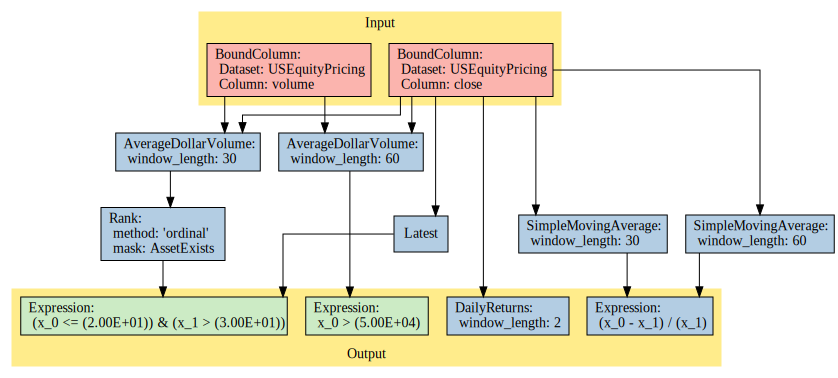

In [7]:
import graphviz
# Render the pipeline as a DAG
pipeline.show_graph()

# TODO: Run The Pipeline

In the code below, run the pipeline for the dates given

In [8]:
import pandas as pd
# Set starting and end dates
start_date = pd.Timestamp('2014-01-06', tz='utc')
end_date = pd.Timestamp('2016-01-05', tz='utc')

# Run our pipeline for the given start and end dates
output = engine.run_pipeline(pipeline, start_date, end_date)

# Display the pipeline output
output.head(10)

30&60 day percent_difference  \
2014-01-06 00:00:00+00:00 Equity(0 [A])                         0.025939   
                          Equity(1 [AAL])                       0.055887   
                          Equity(2 [AAP])                       0.051009   
                          Equity(3 [AAPL])                      0.035906   
                          Equity(4 [ABBV])                      0.033018   
                          Equity(5 [ABC])                       0.031708   
                          Equity(6 [ABT])                       0.013473   
                          Equity(7 [ACN])                       0.023726   
                          Equity(8 [ADBE])                      0.030372   
                          Equity(9 [ADI])                       0.012433   

                                            customer_filter  daily_returns  
2014-01-06 00:00:00+00:00 Equity(0 [A])               False       0.006951  
                          Equity(1 [AAL])             False       0.046523  
                          Equity(2 [AAP])             False       0.028611  
                          Equity(3 [AAPL])             True      -0.021972  
                          Equity(4 [ABBV])            False       0.006147  
                          Equity(5 [ABC])             False       0.000704  
                          Equity(6 [ABT])             False       0.010701  
                          Equity(7 [ACN])             False       0.003335  
                          Equity(8 [ADBE])            False      -0.002193  
                          Equity(9 [ADI])             False       0.006708

In [9]:
output.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 243777 entries, (2014-01-06 00:00:00+00:00, Equity(0 [A])) to (2016-01-05 00:00:00+00:00, Equity(490 [ZTS]))
Data columns (total 3 columns):
30&60 day percent_difference    243777 non-null float64
customer_filter                 243777 non-null bool
daily_returns                   243766 non-null float64
dtypes: bool(1), float64(2)
memory usage: 4.9+ MB


# GET DATA

In [12]:
# Get the values in index level 1 and save them to a list
universe_tickers = output.index.get_level_values(1).values.tolist()

# Display the tickers
universe_tickers

[Equity(0 [A]),
 Equity(1 [AAL]),
 Equity(2 [AAP]),
 Equity(3 [AAPL]),
 Equity(4 [ABBV]),
 Equity(5 [ABC]),
 Equity(6 [ABT]),
 Equity(7 [ACN]),
 Equity(8 [ADBE]),
 Equity(9 [ADI]),
 Equity(10 [ADM]),
 Equity(11 [ADP]),
 Equity(12 [ADS]),
 Equity(13 [ADSK]),
 Equity(14 [AEE]),
 Equity(15 [AEP]),
 Equity(16 [AES]),
 Equity(17 [AET]),
 Equity(18 [AFL]),
 Equity(19 [AGN]),
 Equity(20 [AIG]),
 Equity(21 [AIV]),
 Equity(22 [AIZ]),
 Equity(23 [AJG]),
 Equity(24 [AKAM]),
 Equity(25 [ALB]),
 Equity(26 [ALGN]),
 Equity(27 [ALK]),
 Equity(28 [ALL]),
 Equity(29 [ALLE]),
 Equity(30 [ALXN]),
 Equity(31 [AMAT]),
 Equity(32 [AMD]),
 Equity(33 [AME]),
 Equity(34 [AMG]),
 Equity(35 [AMGN]),
 Equity(36 [AMP]),
 Equity(37 [AMT]),
 Equity(38 [AMZN]),
 Equity(39 [ANDV]),
 Equity(40 [ANSS]),
 Equity(41 [ANTM]),
 Equity(42 [AON]),
 Equity(43 [AOS]),
 Equity(44 [APA]),
 Equity(45 [APC]),
 Equity(46 [APD]),
 Equity(47 [APH]),
 Equity(48 [ARE]),
 Equity(49 [ARNC]),
 Equity(50 [ATVI]),
 Equity(51 [AVB]),
 Equity(

In [13]:
from zipline.data.data_portal import DataPortal

# Create a data portal
data_portal = DataPortal(bundle_data.asset_finder,
                         trading_calendar = trading_calendar,
                         first_trading_day = bundle_data.equity_daily_bar_reader.first_trading_day,
                         equity_daily_reader = bundle_data.equity_daily_bar_reader,
                         adjustment_reader = bundle_data.adjustment_reader)

In [ ]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    
    # Set the given start and end dates to Timestamps. The frequency string C is used to
    # indicate that a CustomBusinessDay DateOffset is used
    end_dt = pd.Timestamp(end_date, tz='UTC', freq='C')
    start_dt = pd.Timestamp(start_date, tz='UTC', freq='C')

    # Get the locations of the start and end dates
    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    # return the historical data for the given window
    return data_portal.get_history_window(assets=assets, end_dt=end_dt, bar_count=end_loc - start_loc,
                                          frequency='1d',
                                          field=field,
                                          data_frequency='daily')

# Get the historical data for the given window
historical_data = get_pricing(data_portal, trading_calendar, universe_tickers,
                              start_date='2014-01-06', end_date='2016-01-05')
# Display the historical data
historical_data

# Solution

[Solution notebook](zipline_coding_exercises_solution.ipynb)